In [1]:
#!pip install scikit-learn
#!pip install tensorflow
#!pip install tensorflow-gpu


In [2]:
import numpy as np

In [3]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [4]:
import random
import os
import numpy as np

crossValidationDataPaths=['NORMALIZED/NumericalData/ML/Training/RightHand','NORMALIZED/NumericalData/ML/Training/LeftHand']
testPaths=['NORMALIZED/NumericalData/ML/Test/RightHand','NORMALIZED/NumericalData/ML/Test/LeftHand']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [5]:
# print(x_shape.shape)
# print(y_shape.shape)

In [6]:
# print(test_x_shape.shape)
# print(test_y_shape.shape)


In [7]:
print('hello')

hello


In [8]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 32 # 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands
#input_shape = (MAX_FRMAE,150) # pose hands xy only
# input_shape = (MAX_FRMAE,1629)
#input_shape = (MAX_FRMAE,1086) # all points but x y only
#input_shape = (MAX_FRMAE,99)  #pose
#input_shape = (MAX_FRMAE,66)  #pose only xy


log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)


# Define and compile the model


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


# # Evaluate the model on the test set
# y_val_pred = model.predict(x_val)
# y_val_pred_classes = np.argmax(y_val_pred, axis=1)
# y_val_true_classes = np.argmax(y_val, axis=1)
# test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
# print(f'Test - Accuracy: {test_accuracy}')




2023-12-30 08:50:30.103629: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-30 08:50:30.129816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-30 08:50:30.129832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-30 08:50:30.130819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-30 08:50:30.136395: I tensorflow/core/platform/cpu_feature_guar

[19, 48, 13, 24, 12, 13, 15, 42, 11, 32, 25, 36, 26, 49, 39, 8, 7, 30, 51, 54, 51, 26, 55, 53, 10, 37, 54, 9, 8, 35, 16, 56, 51, 19, 18, 44, 41, 3, 8, 30, 28, 20, 14, 26, 30, 35, 13, 10, 39, 7, 42, 5, 4, 52, 54, 30, 26, 21, 32, 57, 53, 53, 51, 38, 28, 46, 17, 30, 38, 35, 33, 20, 29, 46, 52, 58, 4, 25, 11, 1, 41, 21, 8, 47, 54, 47, 35, 11, 6, 34, 4, 18, 49, 56, 51, 29, 27, 25, 58, 55, 53, 0, 49, 50, 57, 20, 17, 52, 56, 29, 26, 58, 52, 51, 10, 17, 9, 20, 12, 0, 27, 56, 40, 34, 0, 12, 20, 27, 56, 49, 43, 33, 10, 34, 10, 10, 54, 46, 14, 5, 14, 22, 18, 5, 47, 46, 43, 11, 3, 32, 15, 4, 44, 32, 7, 16, 37, 10, 20, 27, 52, 42, 48, 17, 15, 17, 56, 6, 7, 57, 54, 10, 50, 56, 4, 27, 51, 36, 36, 11, 27, 58, 57, 42, 45, 13, 27, 17, 7, 51, 26, 23, 33, 20, 8, 28, 15, 59, 56, 27, 0, 52, 31, 24, 13, 35, 55, 43, 27, 51, 47, 57, 27, 22, 16, 33, 49, 36, 27, 13, 8, 41, 54, 8, 22, 21, 51, 17, 21, 44, 30, 59, 27, 12, 38, 8, 22, 24, 16, 40, 14, 57, 27, 39, 58, 54, 47, 19, 24, 44, 11, 23, 6, 12, 18, 53, 38, 1, 2

2023-12-30 08:50:31.892667: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-12-30 08:50:31.892688: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2023-12-30 08:50:31.892690: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2023-12-30 08:50:31.892769: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2023-12-30 08:50:31.892778: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2023-12-30 08:50:31.892780: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1703904635.400642  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8965 - accuracy: 0.0603

W0000 00:00:1703904644.624075  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 41ms/step - loss: 3.8942 - accuracy: 0.0607 - val_loss: 3.4497 - val_accuracy: 0.1455
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.3147 - accuracy: 0.1757 - val_loss: 2.9015 - val_accuracy: 0.3097
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.8928 - accuracy: 0.2687 - val_loss: 2.5100 - val_accuracy: 0.4229
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.5675 - accuracy: 0.3461 - val_loss: 2.1788 - val_accuracy: 0.5112
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.3058 - accuracy: 0.4015 - val_loss: 1.9662 - val_accuracy: 0.5672
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 2.0984 - accuracy: 0.4537 - val_loss: 1.7628 - val_accuracy: 0.5970
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9204 - accuracy: 0.5075 - val_loss: 1.5439 - val_accuracy: 0.6505
Epo

W0000 00:00:1703905486.467413  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 1: 0.9552238805970149
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.591692789968652
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1703905491.060029  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9303 - accuracy: 0.0609

W0000 00:00:1703905500.132011  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.9303 - accuracy: 0.0609 - val_loss: 3.5229 - val_accuracy: 0.1719
Epoch 2/200
226/226 [==============================] - 9s 38ms/step - loss: 3.3943 - accuracy: 0.1597 - val_loss: 2.9925 - val_accuracy: 0.2864
Epoch 3/200
226/226 [==============================] - 9s 38ms/step - loss: 2.9993 - accuracy: 0.2428 - val_loss: 2.6296 - val_accuracy: 0.3549
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 2.6845 - accuracy: 0.3178 - val_loss: 2.3282 - val_accuracy: 0.4695
Epoch 5/200
226/226 [==============================] - 9s 38ms/step - loss: 2.4722 - accuracy: 0.3568 - val_loss: 2.1218 - val_accuracy: 0.5380
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 2.2726 - accuracy: 0.4135 - val_loss: 1.9256 - val_accuracy: 0.5629
Epoch 7/200
226/226 [==============================] - 9s 38ms/step - loss: 2.0913 - accuracy: 0.4553 - val_loss: 1.7111 - val_accuracy: 0.6102
Epo

W0000 00:00:1703906255.303551  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 12ms/step
Validation Accuracy Fold 2: 0.9514321295143213
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5587774294670846
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1703906259.649409  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.9679 - accuracy: 0.0517

W0000 00:00:1703906268.765233  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 41ms/step - loss: 3.9671 - accuracy: 0.0517 - val_loss: 3.6615 - val_accuracy: 0.1619
Epoch 2/200
226/226 [==============================] - 9s 38ms/step - loss: 3.4569 - accuracy: 0.1556 - val_loss: 3.1354 - val_accuracy: 0.2877
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 3.0701 - accuracy: 0.2208 - val_loss: 2.7209 - val_accuracy: 0.3898
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 2.7834 - accuracy: 0.2916 - val_loss: 2.4627 - val_accuracy: 0.4545
Epoch 5/200
226/226 [==============================] - 9s 38ms/step - loss: 2.5818 - accuracy: 0.3424 - val_loss: 2.2426 - val_accuracy: 0.4994
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 2.3554 - accuracy: 0.3940 - val_loss: 1.9859 - val_accuracy: 0.5940
Epoch 7/200
226/226 [==============================] - 9s 38ms/step - loss: 2.1735 - accuracy: 0.4364 - val_loss: 1.7814 - val_accuracy: 0.6139
Epo

W0000 00:00:1703907219.711496  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 3: 0.9701120797011208
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5744514106583072
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1703907224.076717  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.7778 - accuracy: 0.0949

W0000 00:00:1703907233.231792  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 41ms/step - loss: 3.7759 - accuracy: 0.0950 - val_loss: 3.3297 - val_accuracy: 0.2142
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.1083 - accuracy: 0.2310 - val_loss: 2.7557 - val_accuracy: 0.3798
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.6761 - accuracy: 0.3262 - val_loss: 2.3554 - val_accuracy: 0.4695
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.3878 - accuracy: 0.3864 - val_loss: 2.0723 - val_accuracy: 0.5293
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1532 - accuracy: 0.4488 - val_loss: 1.9020 - val_accuracy: 0.5392
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9507 - accuracy: 0.5010 - val_loss: 1.6402 - val_accuracy: 0.6376
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.7962 - accuracy: 0.5340 - val_loss: 1.4768 - val_accuracy: 0.6775
Epo

W0000 00:00:1703908151.417997  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 4: 0.9663760896637609
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.609717868338558
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1703908155.657091  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.8122 - accuracy: 0.0807

W0000 00:00:1703908164.823225  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.8122 - accuracy: 0.0807 - val_loss: 3.3555 - val_accuracy: 0.1681
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.1682 - accuracy: 0.2006 - val_loss: 2.7701 - val_accuracy: 0.2951
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.7816 - accuracy: 0.2843 - val_loss: 2.4329 - val_accuracy: 0.3798
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.4759 - accuracy: 0.3550 - val_loss: 2.1281 - val_accuracy: 0.5093
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.2592 - accuracy: 0.4091 - val_loss: 1.8513 - val_accuracy: 0.5928
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 2.0810 - accuracy: 0.4577 - val_loss: 1.6772 - val_accuracy: 0.6376
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9129 - accuracy: 0.4971 - val_loss: 1.5548 - val_accuracy: 0.6588
Epo

W0000 00:00:1703909047.990602  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 5: 0.975093399750934
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6136363636363636
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1703909052.467416  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8504 - accuracy: 0.0849

W0000 00:00:1703909061.636800  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.8493 - accuracy: 0.0852 - val_loss: 3.4362 - val_accuracy: 0.1756
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.2783 - accuracy: 0.1967 - val_loss: 2.9348 - val_accuracy: 0.2989
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.8546 - accuracy: 0.2937 - val_loss: 2.4779 - val_accuracy: 0.4209
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.5423 - accuracy: 0.3574 - val_loss: 2.1905 - val_accuracy: 0.5044
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.2959 - accuracy: 0.4169 - val_loss: 1.9824 - val_accuracy: 0.5318
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1077 - accuracy: 0.4528 - val_loss: 1.7768 - val_accuracy: 0.6015
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9299 - accuracy: 0.4971 - val_loss: 1.6068 - val_accuracy: 0.6364
Epo

W0000 00:00:1703909959.316124  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 6: 0.958904109589041
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5540752351097179
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1703909965.007769  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.8187 - accuracy: 0.0891

W0000 00:00:1703909974.776299  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 44ms/step - loss: 3.8187 - accuracy: 0.0891 - val_loss: 3.3172 - val_accuracy: 0.2179
Epoch 2/200
226/226 [==============================] - 9s 40ms/step - loss: 3.1451 - accuracy: 0.2211 - val_loss: 2.7066 - val_accuracy: 0.4110
Epoch 3/200
226/226 [==============================] - 9s 40ms/step - loss: 2.7211 - accuracy: 0.3154 - val_loss: 2.3738 - val_accuracy: 0.4458
Epoch 4/200
226/226 [==============================] - 9s 40ms/step - loss: 2.4104 - accuracy: 0.3854 - val_loss: 2.0095 - val_accuracy: 0.5592
Epoch 5/200
226/226 [==============================] - 9s 40ms/step - loss: 2.1654 - accuracy: 0.4496 - val_loss: 1.7881 - val_accuracy: 0.6227
Epoch 6/200
226/226 [==============================] - 9s 40ms/step - loss: 1.9858 - accuracy: 0.4799 - val_loss: 1.5782 - val_accuracy: 0.6376
Epoch 7/200
226/226 [==============================] - 9s 40ms/step - loss: 1.8414 - accuracy: 0.5140 - val_loss: 1.4811 - val_accuracy: 0.6737
Epo

W0000 00:00:1703910744.909955  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 7: 0.9526774595267746
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5940438871473355
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1703910750.451828  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8694 - accuracy: 0.0672

W0000 00:00:1703910759.698226  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.8678 - accuracy: 0.0678 - val_loss: 3.4915 - val_accuracy: 0.1594
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.2355 - accuracy: 0.1994 - val_loss: 2.8241 - val_accuracy: 0.3151
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.8106 - accuracy: 0.2897 - val_loss: 2.4446 - val_accuracy: 0.4496
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.5057 - accuracy: 0.3626 - val_loss: 2.1255 - val_accuracy: 0.5392
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.2907 - accuracy: 0.4052 - val_loss: 1.9247 - val_accuracy: 0.5928
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1199 - accuracy: 0.4498 - val_loss: 1.7464 - val_accuracy: 0.6264
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9322 - accuracy: 0.5048 - val_loss: 1.5491 - val_accuracy: 0.6501
Epo

W0000 00:00:1703911499.509054  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 8: 0.9713574097135741
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5509404388714734
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1703911504.444252  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.7979 - accuracy: 0.0793

W0000 00:00:1703911514.093661  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 43ms/step - loss: 3.7962 - accuracy: 0.0797 - val_loss: 3.3302 - val_accuracy: 0.1980
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.1263 - accuracy: 0.2154 - val_loss: 2.6899 - val_accuracy: 0.3661
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.6906 - accuracy: 0.3132 - val_loss: 2.2817 - val_accuracy: 0.4658
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.3879 - accuracy: 0.3921 - val_loss: 1.9905 - val_accuracy: 0.5915
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1790 - accuracy: 0.4308 - val_loss: 1.7944 - val_accuracy: 0.6264
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9789 - accuracy: 0.4808 - val_loss: 1.7239 - val_accuracy: 0.6077
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.8510 - accuracy: 0.5138 - val_loss: 1.5298 - val_accuracy: 0.6389
Epo

W0000 00:00:1703912222.626923  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 9: 0.9726027397260274
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5940438871473355
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1703912228.320093  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.9068 - accuracy: 0.0664

W0000 00:00:1703912237.642484  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 42ms/step - loss: 3.9068 - accuracy: 0.0664 - val_loss: 3.5146 - val_accuracy: 0.1631
Epoch 2/200
226/226 [==============================] - 9s 40ms/step - loss: 3.3670 - accuracy: 0.1727 - val_loss: 2.9530 - val_accuracy: 0.2939
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.8944 - accuracy: 0.2727 - val_loss: 2.4544 - val_accuracy: 0.4545
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.5653 - accuracy: 0.3434 - val_loss: 2.1349 - val_accuracy: 0.5342
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.2846 - accuracy: 0.4041 - val_loss: 1.8785 - val_accuracy: 0.6177
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 2.0857 - accuracy: 0.4624 - val_loss: 1.6673 - val_accuracy: 0.6675
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9233 - accuracy: 0.4965 - val_loss: 1.4496 - val_accuracy: 0.6974
Epo

W0000 00:00:1703913219.184153  304755 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 10: 0.9726027397260274
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5940438871473355
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [9]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.591692789968652, 0.5587774294670846, 0.5744514106583072, 0.609717868338558, 0.6136363636363636, 0.5540752351097179, 0.5940438871473355, 0.5509404388714734, 0.5940438871473355, 0.5940438871473355]
0.5835423197492162
[0.9552238805970149, 0.9514321295143213, 0.9701120797011208, 0.9663760896637609, 0.975093399750934, 0.958904109589041, 0.9526774595267746, 0.9713574097135741, 0.9726027397260274, 0.9726027397260274]
0.9646382037508598


In [10]:
# print(conf_matrixes)

In [11]:
# average_conf_mat = np.sum(conf_matrixes, axis=0)
# average_conf_mat

test accuracies:  [0.591692789968652, 0.5587774294670846, 0.5744514106583072, 0.609717868338558, 0.6136363636363636, 0.5540752351097179, 0.5940438871473355, 0.5509404388714734, 0.5940438871473355, 0.5940438871473355] 4
validation accuracies:  [0.9552238805970149, 0.9514321295143213, 0.9701120797011208, 0.9663760896637609, 0.975093399750934, 0.958904109589041, 0.9526774595267746, 0.9713574097135741, 0.9726027397260274, 0.9726027397260274]
60


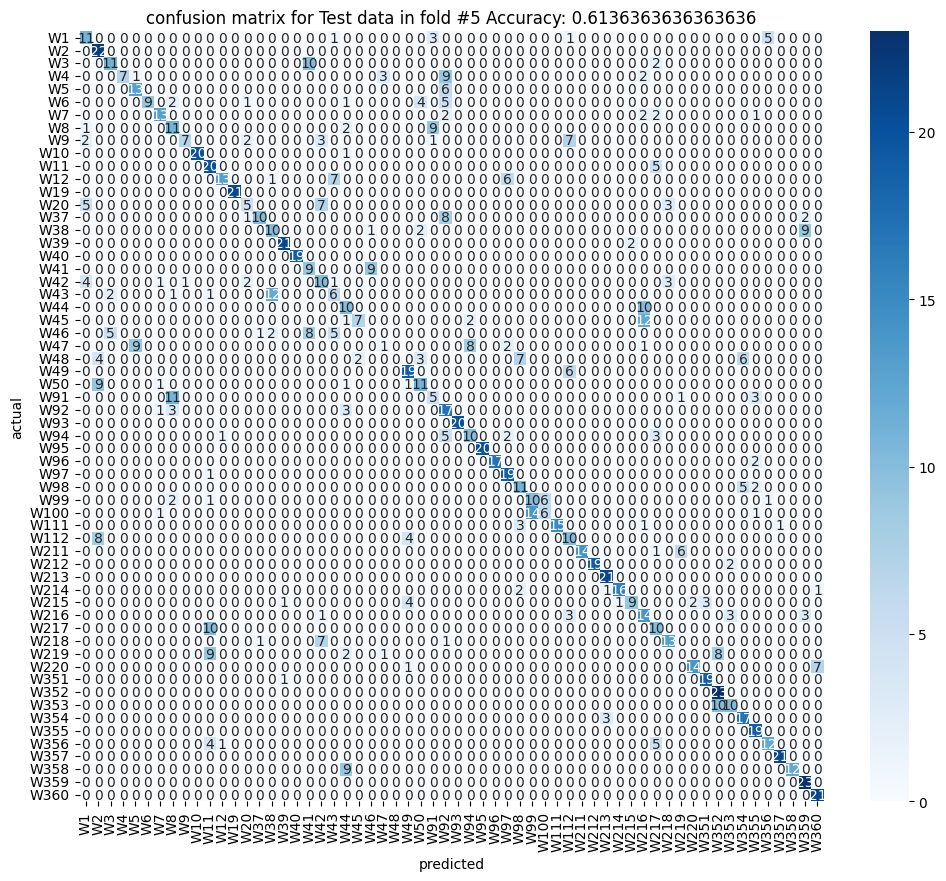

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

plt.savefig(f'HandPose_RightHand_LeftHandFlipped_acc_{bestTest-1}_{test_accuracies[bestTest-1]}.png')

In [13]:
# print(y_val_pred.shape)
# print(y_val_pred)
# print(y_val_pred[0][10])

# bestTest-1

plt.close

<function matplotlib.pyplot.close(fig=None)>

In [14]:
# y_val_pred = model.predict(x_val)
# print(y_val_pred[0])
# y_val_pred_classes = np.argmax(y_val_pred, axis=1)
# y_val_true_classes = np.argmax(y_val, axis=1)

In [15]:
print('Hello')

Hello
